In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/its-fraud/train.csv
/kaggle/input/its-fraud/test.csv
/kaggle/input/its-fraud/mock_submission.csv


**IMPORTING PACKAGES**

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

In [3]:
train_full = pd.read_csv("../input/its-fraud/train.csv")
test_full = pd.read_csv("../input/its-fraud/test.csv")

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
train_full = reduce_mem_usage(train_full)
test_full = reduce_mem_usage(test_full)

Mem. usage decreased to 484.48 Mb (67.0% reduction)
Mem. usage decreased to 156.00 Mb (68.0% reduction)


 common issues with dataset:

-> Attributes Formatting (data types)

-> Missing Data

-> Replacement or Drop

-> Response Variable

In [6]:
train_full.info(verbose=True, null_counts=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442905 entries, 0 to 442904
Data columns (total 434 columns):
 #    Column          Non-Null Count   Dtype  
---   ------          --------------   -----  
 0    TransactionID   442905 non-null  int32  
 1    isFraud         442905 non-null  int8   
 2    TransactionDT   442905 non-null  int32  
 3    TransactionAmt  442905 non-null  float16
 4    ProductCD       442905 non-null  object 
 5    card1           442905 non-null  int16  
 6    card2           436201 non-null  float16
 7    card3           441724 non-null  float16
 8    card4           441714 non-null  object 
 9    card5           439730 non-null  float16
 10   card6           441720 non-null  object 
 11   addr1           393811 non-null  float16
 12   addr2           393811 non-null  float16
 13   dist1           178614 non-null  float16
 14   dist2           28168 non-null   float16
 15   P_emaildomain   371974 non-null  object 
 16   R_emaildomain   102728 non-null  obj

In [7]:
train_full.info(verbose=True, null_counts=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442905 entries, 0 to 442904
Data columns (total 434 columns):
 #    Column          Non-Null Count   Dtype  
---   ------          --------------   -----  
 0    TransactionID   442905 non-null  int32  
 1    isFraud         442905 non-null  int8   
 2    TransactionDT   442905 non-null  int32  
 3    TransactionAmt  442905 non-null  float16
 4    ProductCD       442905 non-null  object 
 5    card1           442905 non-null  int16  
 6    card2           436201 non-null  float16
 7    card3           441724 non-null  float16
 8    card4           441714 non-null  object 
 9    card5           439730 non-null  float16
 10   card6           441720 non-null  object 
 11   addr1           393811 non-null  float16
 12   addr2           393811 non-null  float16
 13   dist1           178614 non-null  float16
 14   dist2           28168 non-null   float16
 15   P_emaildomain   371974 non-null  object 
 16   R_emaildomain   102728 non-null  obj

Most of the column names have been masked for privacy protection. Without accurate description of the fields meaning, it would be difficult to determine the type of data. Fortunately, Vesta have provided us with high-level summary of data.

Let's recall the avaiable groups of information that were provided for us:

1. Identity Table:

    * id_01 - id_38: contains network connection information
    
    * DeviceType and DeviceInfo
    
2. Transactional Table:

    * card1 - card6: card information
    
    * addr: address
    
    * dist: distance

    * P_ and (R__) emaildomain: purchaser and recipient email domain
    
    * C1-C14: counting
    
    * D1-D15: timedelta, such as days between previous transaction, etc.
    
    * M1-M9: match, such as names on card and address, etc.
    
    * V1-V339: Vesta engineered features
    
    * ProductCD: product code, the product for each transaction
    
    * TransactionDT: timedelta from a given reference datetime
    
    * TransactionAMT: transaction payment amount in USD    
    
## Missing Data
    
Let's take a look at the missing data for the **categorical variables** first:

In [8]:
train_full_cat = train_full.filter(regex='id|card|ProductCD|addr|email|M|DeviceType|DeviceInfo')

<AxesSubplot:>

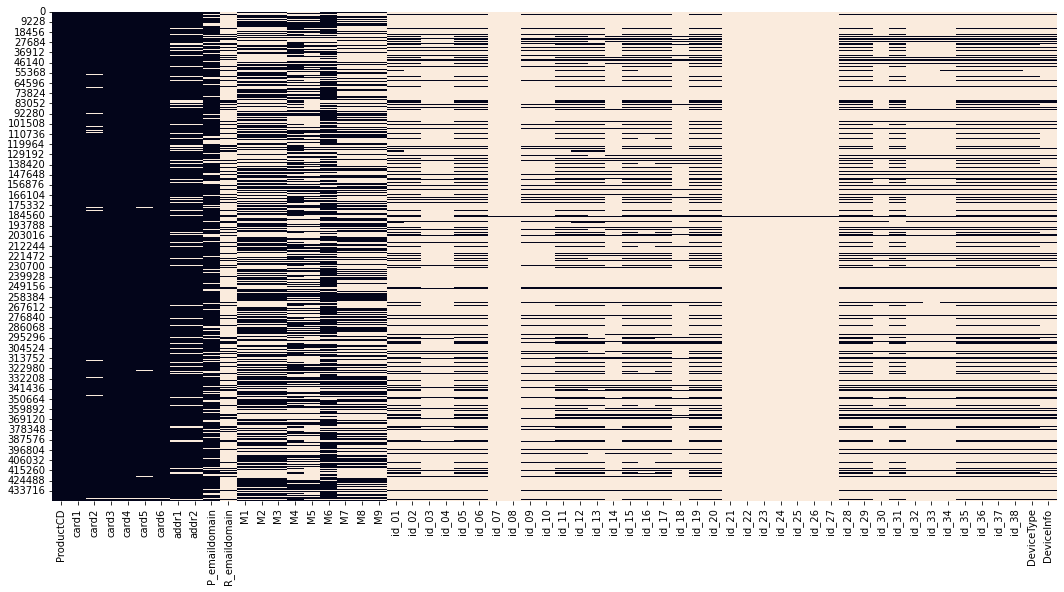

In [9]:
plt.figure(figsize=(18,9))
sns.heatmap(train_full_cat.isnull(), cbar= False)

**Observation**: We can see that our data has a lot of missing values. White color presents missing values.

1. Most M columns missing almost if not all data

2. Id_07, 08 and id_21-27 missing most data

3. Id_01, id_12, card1, card2 contains mostly non-null. Perhaps, these columns contain unique ID information, and therefore, cannot be null. Let's double check the number of missing in these columns: 

In [10]:
train_full_cat[['id_01','id_12','card1','card2']].info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442905 entries, 0 to 442904
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id_01   107977 non-null  float16
 1   id_12   107977 non-null  object 
 2   card1   442905 non-null  int16  
 3   card2   436201 non-null  float16
dtypes: float16(2), int16(1), object(1)
memory usage: 5.9+ MB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


Yes, they are indeed complete, except for card 2. If I were to guess, card1 could be first name and card2 could be last name.

Now let's check out missing data for **numerical variables**:

<AxesSubplot:>

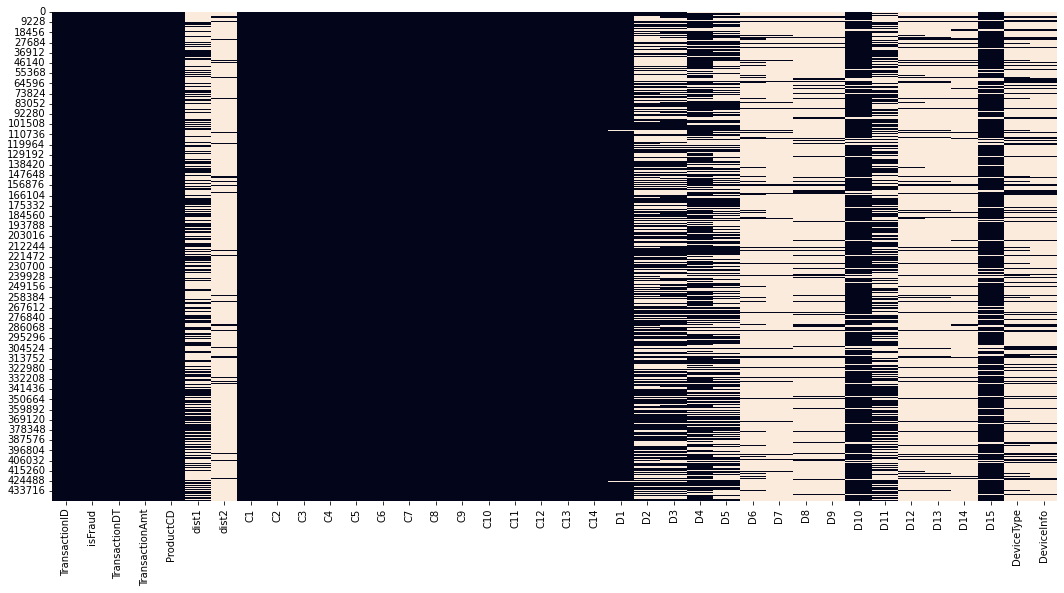

In [11]:
train_full_num = train_full.filter(regex='isFraud|TransactionDT|TransactionAmt|dist|C|D')
plt.figure(figsize=(18,9))
sns.heatmap(train_full_num.isnull(), cbar= False)

**Observation**: 
    
    1. Basic information about transaction such as ID, DT, amount and type of product is complete 
    
    2. Dist1 and dist2 is very sparse.
    
    3. C columns are complete
    
    4. Most D columns are sparse except D1
    
Lastly, we want to check for data completeness of **Vesta's engineered features**:

**Observation**:The repeated missing patterns in the V columns suggest that many V columns are related and perhaps trying to describe certain characteristics of a transaction. For example, columns V322-V399 have identical missing locations.

Let's verify our intuition with correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another:

Text(0.5, 1.0, 'Distribution of TransactionDT')

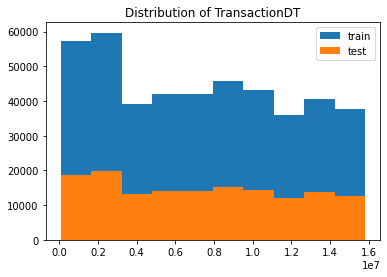

In [12]:
plt.hist(train_full['TransactionDT'], label='train')
plt.hist(test_full['TransactionDT'], label='test')
plt.legend()
plt.title('Distribution of TransactionDT')

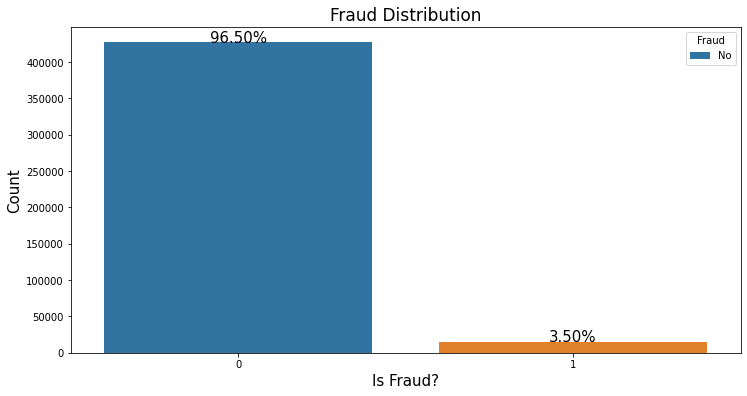

In [13]:
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'isFraud', data = train_full)
g.set_title("Fraud Distribution", fontsize = 17)
g.set_xlabel("Is Fraud?", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
plt.legend(title='Fraud', labels=['No', 'Yes'])

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train_full) * 100),
            ha="center", fontsize=15) 

**Observation**:The fraud percentage is quite high: 7.85% for the complete observations (identity + transaction). We can see there is a class imbalance problem, where occurence of one class is significantly higher than another. This will lead to much a higher false negative - tendency of picking "not fraud". We can mitigate this issue by using two common methods:

1. Cost function based approaches

2. Sampling based approaches

# Explore Categorical Features
**Categorical Features:**

**1. Transactional Table:**
    
    ProductCD

    card1 - card6

    addr1, addr2

    Pemaildomain Remaildomain

    M1 - M9
    
    
**2. Identity Table**

    DeviceType

    DeviceInfo
    
    id12 - id38

Let's take a quick look at these categorical features:

In [14]:
train_full_cat.head()

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,5033,269.0,150.0,mastercard,224.0,debit,330.0,87.0,gmail.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W,4527,376.0,150.0,visa,226.0,debit,441.0,87.0,gmail.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W,2772,512.0,150.0,visa,226.0,debit,143.0,87.0,centurylink.net,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H,14290,512.0,150.0,visa,226.0,debit,177.0,87.0,yahoo.com,...,chrome 62.0,24.0,1920x1080,match_status:2,T,F,T,T,desktop,Windows
4,W,12839,321.0,150.0,visa,226.0,debit,220.0,87.0,gmail.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Examine Product Code

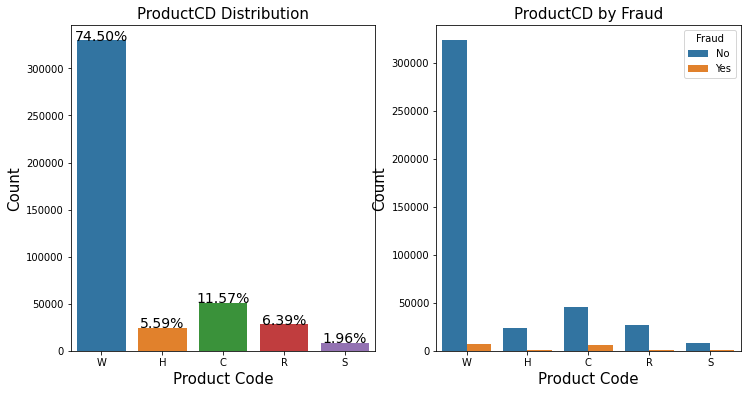

In [15]:
plt.figure(figsize=(12,6))

total = len(train_full_cat)

plt.subplot(121)
g = sns.countplot(x = 'ProductCD', data = train_full_cat)
g.set_title('ProductCD Distribution', fontsize = 15)
g.set_xlabel("Product Code", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train_full)
g1.set_title('ProductCD by Fraud', fontsize = 15)
g1.set_xlabel("Product Code", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

**Observations**: C is the most frequent product category. Product C also have the highest count of fraud. We can obtain the proportion of fraud for each product category:

In [16]:
train_full[train_full['isFraud'] == 1]['ProductCD'].value_counts(normalize = True)

W    0.434019
C    0.386720
H    0.076789
R    0.069497
S    0.032974
Name: ProductCD, dtype: float64

In [17]:
# grouped table
train_full.groupby('ProductCD')['isFraud'].value_counts(normalize = True)

ProductCD  isFraud
C          0          0.883050
           1          0.116950
H          0          0.951902
           1          0.048098
R          0          0.961926
           1          0.038074
S          0          0.941068
           1          0.058932
W          0          0.979616
           1          0.020384
Name: isFraud, dtype: float64

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'C'),
  Text(1, 0, 'H'),
  Text(2, 0, 'R'),
  Text(3, 0, 'S'),
  Text(4, 0, 'W')])

<Figure size 864x864 with 0 Axes>

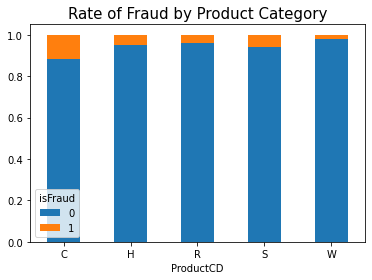

In [18]:
# visualization of table
plt.figure(figsize=(12,12))
a = train_full.groupby('ProductCD')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
a.set_title('Rate of Fraud by Product Category', fontsize = 15)
plt.xticks(rotation='horizontal')

**Conclusion**: Product C takes up 67.5% of fraud cases for transactions that have identity. And also have highest rate of fraud: 12%, more than double any other class of product.

**Question**: Why product C? Is there any additional information that help us better understand product C high fraud rate?

We have 2 numerical variables that we can compare between groups of products:

TransactionDT: timedelta from a given reference datetime

TransactionAmt: transaction payment amount in USD

<AxesSubplot:xlabel='ProductCD', ylabel='TransactionAmt'>

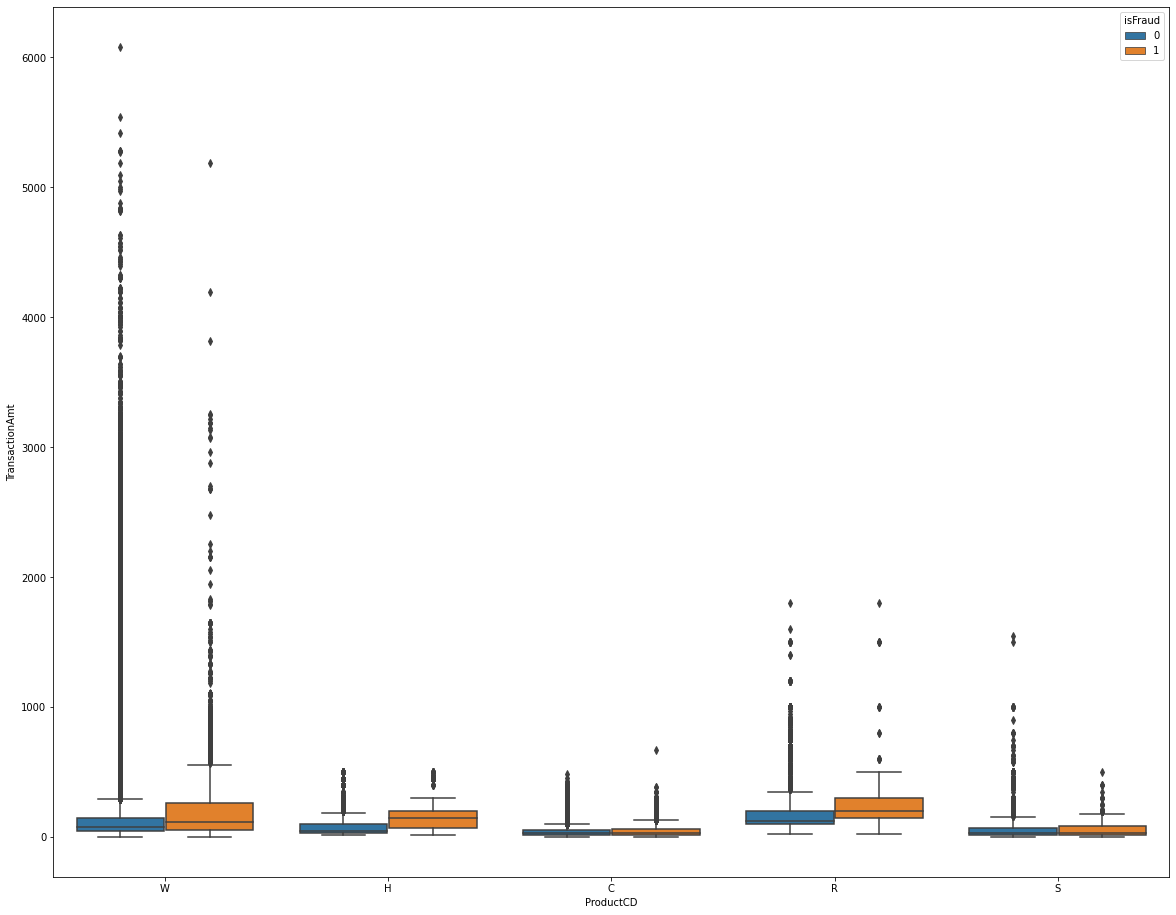

In [19]:
plt.figure(figsize=(20,16))
sns.boxplot(x = 'ProductCD', y = 'TransactionAmt', hue = 'isFraud', data = train_full)

**Observation**: Product C are items with low dollar value.

<AxesSubplot:xlabel='ProductCD', ylabel='TransactionDT'>

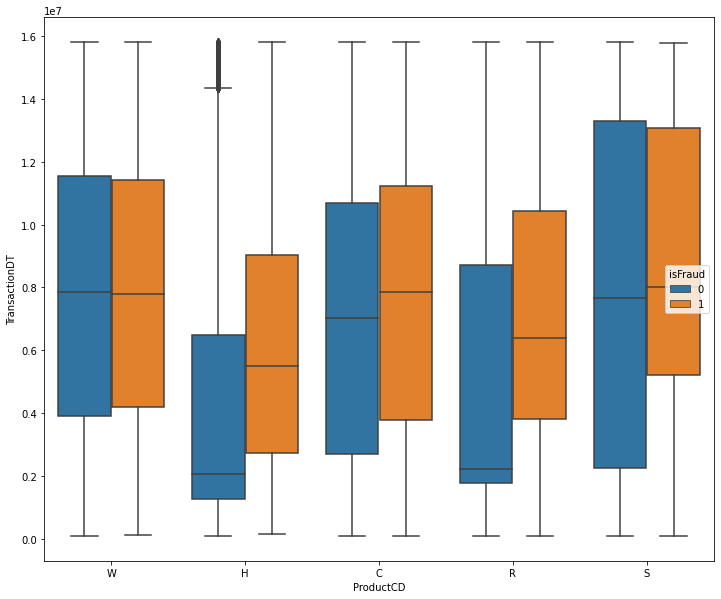

In [20]:
plt.figure(figsize=(12,10))
sns.boxplot(x = 'ProductCD', y = 'TransactionDT', hue = 'isFraud', data = train_full)

**Observation**: All products have same min and max timedelta range. 

**Conclusion**:The plot suggests little to no difference in timedelta accross all groups.

## Examine Card 1,2,3,5

The card 1,2,3, and 5 was represented as numerical values, temping us to plot the histogram. However, we need to remember that card columns were classified as categorical variables. Meaning it's likely that these numerical variables were coded for categorical variables.

In [21]:
train_full_cat.describe().loc[:,'card1':'card5']

,card1,card2,card3,card5
count,442905.000000,436201.0,441724.0,439730.0
mean,9901.266082,NaN,NaN,NaN
std,4901.960786,NaN,0.0,0.0
min,1001.000000,100.0,100.0,100.0
25%,6019.000000,214.0,150.0,166.0
50%,9680.000000,361.0,150.0,226.0
75%,14184.000000,512.0,150.0,226.0
max,18396.000000,600.0,231.0,237.0


In [22]:
train_full_cat.loc[:,'card1':'card5'].nunique()

card1    12559
card2      500
card3      110
card4        4
card5      115
dtype: int64

Card 1 contains 8499 unique values, suggesting card 1 may have been ID of the card. Card 2,3 and 5 have less unique values, so perhaps they could be expiration date, or combinations that generate card identity? Since we don't know how these information was scrammbled, we might pickup patterns generated by encryption algorithm instead of data. No further analysis should be done unless more infomation is given.

Same goes for the addr1 and addr2.

## Examine Card 4 and 6

### Card 4: Card Network

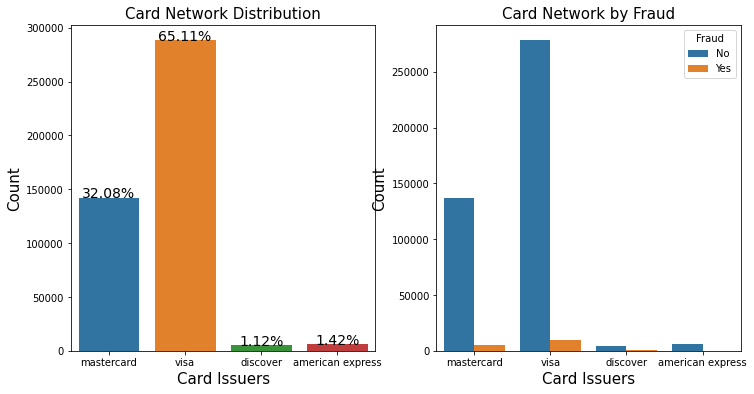

In [23]:
plt.figure(figsize=(12,6))

total = len(train_full_cat)

plt.subplot(121)
g = sns.countplot(x = 'card4', data = train_full_cat)
g.set_title('Card Network Distribution', fontsize = 15)
g.set_xlabel("Card Issuers", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='card4', hue='isFraud', data=train_full)
g1.set_title('Card Network by Fraud', fontsize = 15)
g1.set_xlabel("Card Issuers", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

**Observation:** Visa card accounts for the highest instances of fraud, but this also because visa is the most popular card type. Again, we can only conclude after comparing the fraud propotion for each card type:

In [24]:
train_full[train_full['isFraud'] == 1]['card4'].value_counts(normalize = True)

visa                0.643642
mastercard          0.318717
discover            0.025676
american express    0.011965
Name: card4, dtype: float64

In [25]:
# grouped table
train_full.groupby('card4')['isFraud'].value_counts(normalize = True)

card4             isFraud
american express  0          0.970513
                  1          0.029487
discover          0          0.920137
                  1          0.079863
mastercard        0          0.965320
                  1          0.034680
visa              0          0.965489
                  1          0.034511
Name: isFraud, dtype: float64

(array([0, 1, 2, 3]),
 [Text(0, 0, 'american express'),
  Text(1, 0, 'discover'),
  Text(2, 0, 'mastercard'),
  Text(3, 0, 'visa')])

<Figure size 864x864 with 0 Axes>

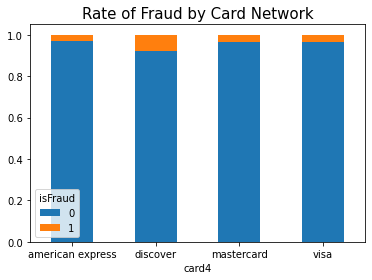

In [26]:
# visualization of table
plt.figure(figsize=(12,12))
b = train_full.groupby('card4')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
b.set_title('Rate of Fraud by Card Network', fontsize = 15)
plt.xticks(rotation='horizontal')

**Conclusion**: Visa accounts for 61% of all fraud occurences. However, when normalized by total number of each type, Visa have fraud rate of only 8%, lower than Mastercard and same as Discovercard. Only American Express have significantly lower fraud rate compare to others.

### Card 6: Card Type

Similarly, we can use the same method of data analysis on this variable:

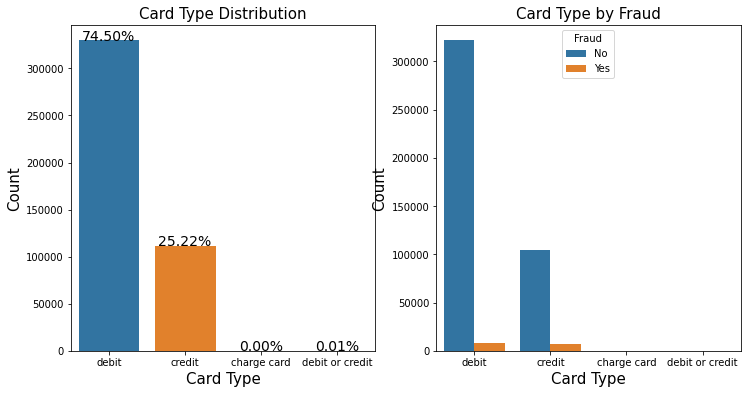

In [27]:
plt.figure(figsize=(12,6))

total = len(train_full_cat)

plt.subplot(121)
g = sns.countplot(x = 'card6', data = train_full)
g.set_title('Card Type Distribution', fontsize = 15)
g.set_xlabel("Card Type", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='card6', hue='isFraud', data=train_full)
g1.set_title('Card Type by Fraud', fontsize = 15)
g1.set_xlabel("Card Type", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

**Observation:** The number of card type are fairly simiar, and so does the fraud cases. 

In [28]:
# grouped table
train_full.groupby('card6')['isFraud'].value_counts(normalize = True)

card6            isFraud
charge card      0          1.000000
credit           0          0.933377
                 1          0.066623
debit            0          0.975695
                 1          0.024305
debit or credit  0          1.000000
Name: isFraud, dtype: float64

(array([0, 1, 2, 3]),
 [Text(0, 0, 'charge card'),
  Text(1, 0, 'credit'),
  Text(2, 0, 'debit'),
  Text(3, 0, 'debit or credit')])

<Figure size 864x864 with 0 Axes>

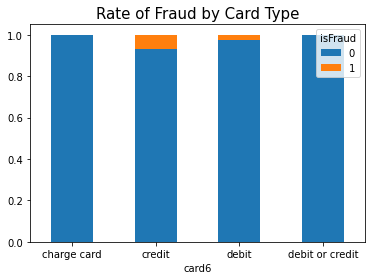

In [29]:
# visualization of table
plt.figure(figsize=(12,12))
b = train_full.groupby('card6')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
b.set_title('Rate of Fraud by Card Type', fontsize = 15)
plt.xticks(rotation='horizontal')

**Observation**: Not much difference in fraud rate between credit card and debit card

## Examine Email Domain

### 1. Purchaser Email

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),
 [Text(0, 0, 'gmail.com'),
  Text(1, 0, 'centurylink.net'),
  Text(2, 0, 'yahoo.com'),
  Text(3, 0, 'anonymous.com'),
  Text(4, 0, 'mac.com'),
  Text(5, 0, 'comcast.net'),
  Text(6, 0, 'optonline.net'),
  Text(7, 0, 'bellsouth.net'),
  Text(8, 0, 'hotmail.com'),
  Text(9, 0, 'aol.com'),
  Text(10, 0, 'me.com'),
  Text(11, 0, 'msn.com'),
  Text(12, 0, 'earthlink.net'),
  Text(13, 0, 'att.net'),
  Text(14, 0, 'cableone.net'),
  Text(15, 0, 'sbcglobal.net'),
  Text(16, 0, 'outlook.es'),
  Text(17, 0, 'suddenlink.net'),
  Text(18, 0, 'icloud.com'),
  Text(19, 0, 'twc.com'),
  Text(20, 0, 'gmx.de'),
  Text(21, 0, 'ymail.com'),
  Text(22, 0, 'verizon.net'),
  Text(23, 0, 'cox.net'),
  Text(24, 0, 'yahoo.es'),
  Text(25, 0, 'ai

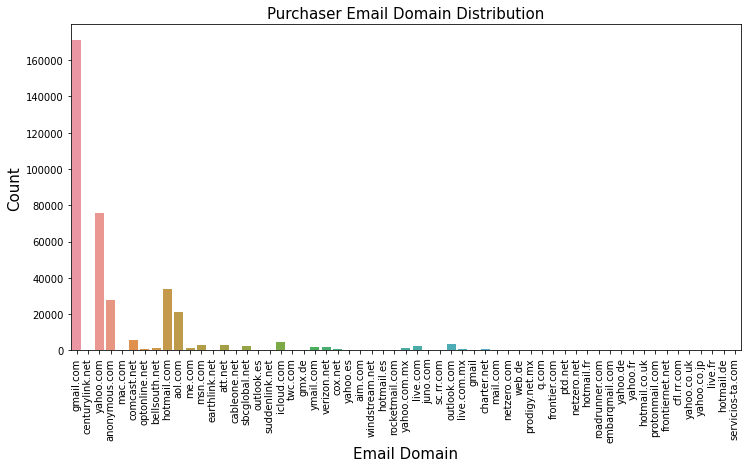

In [30]:
plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_emaildomain', data = train_full)
g.set_title('Purchaser Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation='vertical')


**Observation**: I see alot of domains came from the same distributors such as hotmail.com, hotmail.fr, yahoo.com, yahoo.fr, yahoo.de, etc. We can group these domains together under the parent distributors.

**Action:** Create P_parent_emaildomain field that remove the part after '.' 

In [31]:
train_full["P_parent_emaildomain"] = train_full["P_emaildomain"].str.split('.', expand = True)[[0]]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 [Text(0, 0, 'gmail'),
  Text(1, 0, 'centurylink'),
  Text(2, 0, 'yahoo'),
  Text(3, 0, 'anonymous'),
  Text(4, 0, 'mac'),
  Text(5, 0, 'comcast'),
  Text(6, 0, 'optonline'),
  Text(7, 0, 'bellsouth'),
  Text(8, 0, 'hotmail'),
  Text(9, 0, 'aol'),
  Text(10, 0, 'me'),
  Text(11, 0, 'msn'),
  Text(12, 0, 'earthlink'),
  Text(13, 0, 'att'),
  Text(14, 0, 'cableone'),
  Text(15, 0, 'sbcglobal'),
  Text(16, 0, 'outlook'),
  Text(17, 0, 'suddenlink'),
  Text(18, 0, 'icloud'),
  Text(19, 0, 'twc'),
  Text(20, 0, 'gmx'),
  Text(21, 0, 'ymail'),
  Text(22, 0, 'verizon'),
  Text(23, 0, 'cox'),
  Text(24, 0, 'aim'),
  Text(25, 0, 'windstream'),
  Text(26, 0, 'rocketmail'),
  Text(27, 0, 'live'),
  Text(28, 0, 'juno'),
  Text(29, 0, 'sc'),
  Text(30, 0, 'charter'),
  Text(31, 0, 'mail'),
  Text(32,

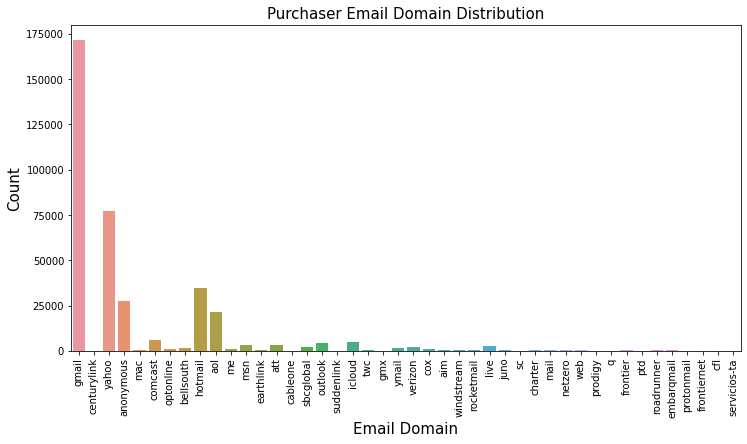

In [32]:
plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_parent_emaildomain', data = train_full)
g.set_title('Purchaser Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

Fewer email domains result in cleaner x tickers. Let's add the fraud rate like in the previous graphs, but this time we add the rate line on top of this graph:

Text(0, 0.5, 'Fraud Rate')

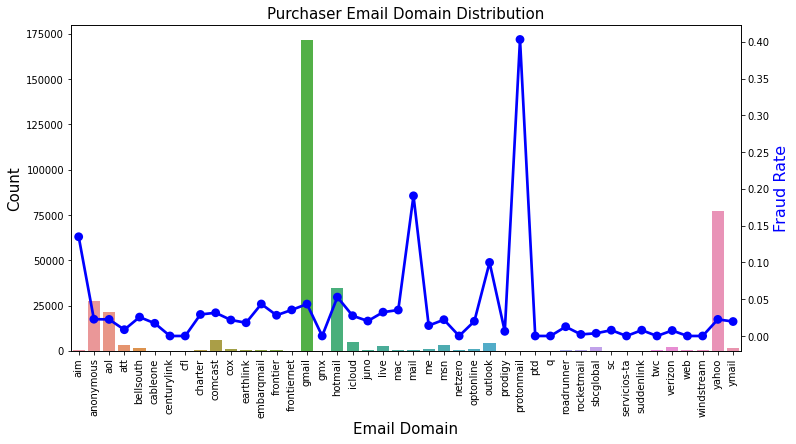

In [33]:
P_emaildomain_fraud_rate = train_full.groupby('P_parent_emaildomain')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_parent_emaildomain', data = train_full, order = P_emaildomain_fraud_rate.index)
g.set_title('Purchaser Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = P_emaildomain_fraud_rate.index, y = P_emaildomain_fraud_rate, color = 'blue')
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")


Protonmail returns an exemely high fraud rate. Almost 80% of transactions from purchaser using protonmail.com were label fraud. Let's double check this result:

In [34]:
protonmail_fraud = len(train_full[(train_full['P_parent_emaildomain'] == "protonmail") & (train_full['isFraud'] == 1)])
protonmail_non_fraud = len(train_full[(train_full['P_parent_emaildomain'] == "protonmail") & (train_full['isFraud'] == 0)])

protonmail_fraud_rate = protonmail_fraud/ (protonmail_fraud + protonmail_non_fraud)
print("Number of protonmail fraud transactions:", protonmail_fraud)
print("Number of protonmail non-fraud transactions:", protonmail_non_fraud)
print("Protonmail fraud rate:", protonmail_fraud_rate)

Number of protonmail fraud transactions: 25
Number of protonmail non-fraud transactions: 37
Protonmail fraud rate: 0.4032258064516129


### 2. Recipient Email

Similarly, we can perform the similar analysis on Recepient email domains

Text(0, 0.5, 'Fraud Rate')

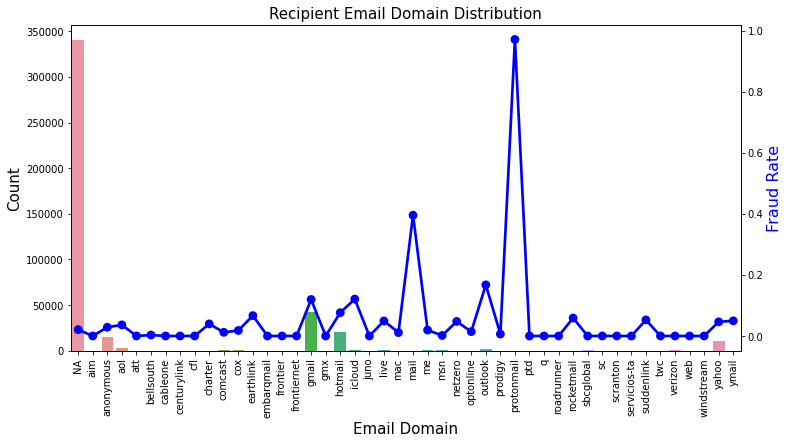

In [35]:
train_full["R_parent_emaildomain"] = train_full["R_emaildomain"].str.split('.', expand = True)[[0]]
train_full["R_parent_emaildomain"].fillna("NA", inplace=True)

R_emaildomain_fraud_rate = train_full.groupby('R_parent_emaildomain')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'R_parent_emaildomain', data = train_full, order = R_emaildomain_fraud_rate.index)
g.set_title('Recipient Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = R_emaildomain_fraud_rate.index, y = R_emaildomain_fraud_rate, color = "blue")
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")

I enjoy this format of visualizing, so I should creat a function that help me explore the categorical format with regard to fraud rate:

In [36]:
def visualize_cat_cariable(variable, df=train_full):
    train_full[variable].fillna("NA", inplace=True)
    variable_fraud_rate = df.groupby(variable)['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]
    
    plt.figure(figsize=(12,6))

    g = sns.countplot(x = variable, data = df, order = variable_fraud_rate.index)
    g.set_title('{} Count'.format(variable), fontsize = 15)
    g.set_xlabel("{}".format(variable), fontsize=15)
    g.set_ylabel("Count", fontsize=15)
    plt.xticks(rotation= "vertical")

    r = g.twinx()
    r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "blue")
    r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")


## Examine M1-M9

The transaction data that has comple identity returns mostly NaN except for M4. Let's check it out:

In [37]:
train_full_cat.loc[:,'M1':'M9'].apply(pd.value_counts)

,M1,M2,M3,M4,M5,M6,M7,M8,M9
F,18.0,25450.0,50666.0,NaN,99584.0,171103.0,158440.0,116401.0,28936.0
M0,NaN,NaN,NaN,147474.0,NaN,NaN,NaN,NaN,NaN
M1,NaN,NaN,NaN,39618.0,NaN,NaN,NaN,NaN,NaN
M2,NaN,NaN,NaN,44666.0,NaN,NaN,NaN,NaN,NaN
T,239505.0,214073.0,188857.0,NaN,80580.0,145016.0,24621.0,66670.0,154135.0


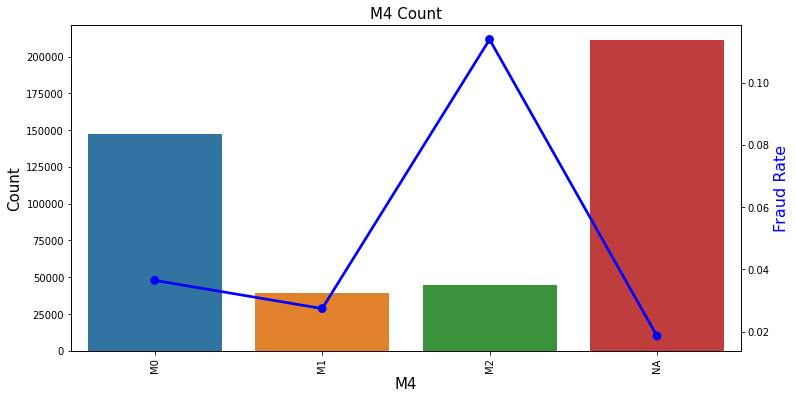

In [38]:
visualize_cat_cariable('M4')

**Observartion**: Not much variation in fraud rate between M0, M1, and M2 in M4

We have gone through all categorical variables in the Transaction Table, now we check out the remaining categorical variables in the Identity Table.

## Examine DeviceType

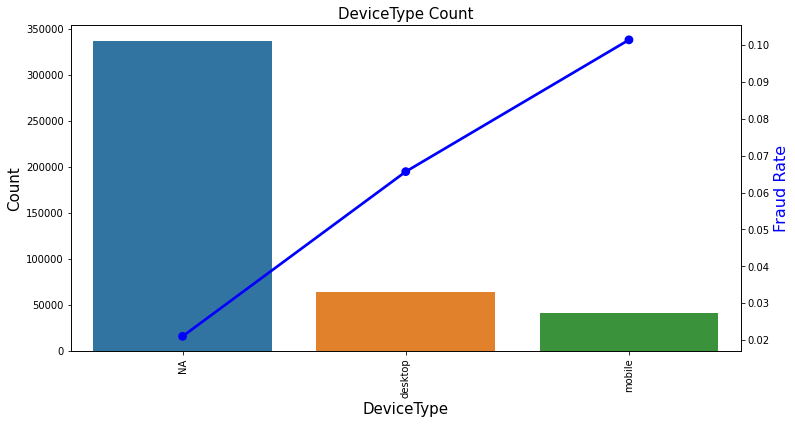

In [39]:
visualize_cat_cariable('DeviceType')

**Observation**: Fraud rate is higher for mobile device compared to desktop

## Examine DeviceInfo

In [40]:
train_full['DeviceInfo'].value_counts()

Windows                    35815
iOS Device                 14773
MacOS                       9434
Trident/7.0                 5605
rv:11.0                     1470
                           ...  
GT-S7275B                      1
F5321 Build/34.2.A.2.47        1
SM-G935T                       1
SM-G900L                       1
SM-J500H                       1
Name: DeviceInfo, Length: 1657, dtype: int64

Since we have way too many devices, it makes more sense to select a few devices that has non-trivial count. Let's select categories that have more than 500 counts:

In [41]:
devicelist = train_full.groupby('DeviceInfo').filter(lambda x: len(x) >500)['DeviceInfo'].unique()

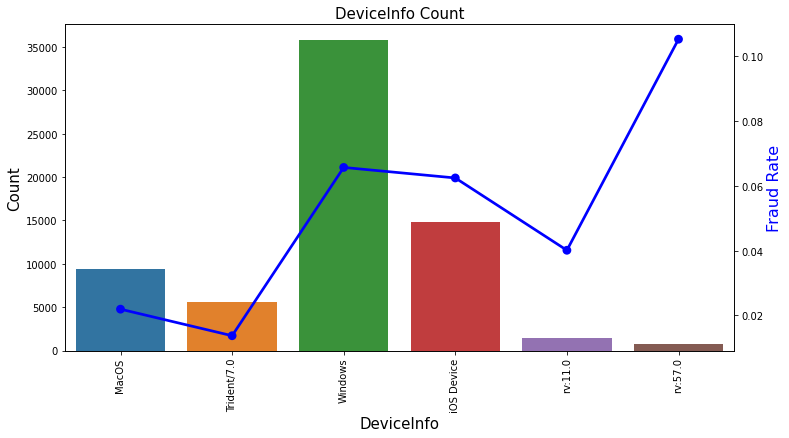

In [42]:
visualize_cat_cariable('DeviceInfo', df = train_full[train_full['DeviceInfo'].isin(devicelist)])

**Observation**: We can see the fraud rate is higher for certain devices

## Examine id12 - id38

We may generate all the graphs for id12 to id38. Depend on your preference, some graphs may be more informative than the other. The graphs below are selected based on:

1. If the graph contains non-masked information (or categories have self-expalainatory meaning)
    * For example: 'Found' and 'NotFound' are two categories that by themselves, don't provide us with any helpful information in understanding their relationships with target variable. Perhaps our learner can pickup on the differences, but it's outside of our domain to understand these variables semantically. 

2. If the graph contains not too many categories so that the xtickers can be plotted legibly

You can plots them all out and select for yourself. Here are some of my picks:

### IP Proxy

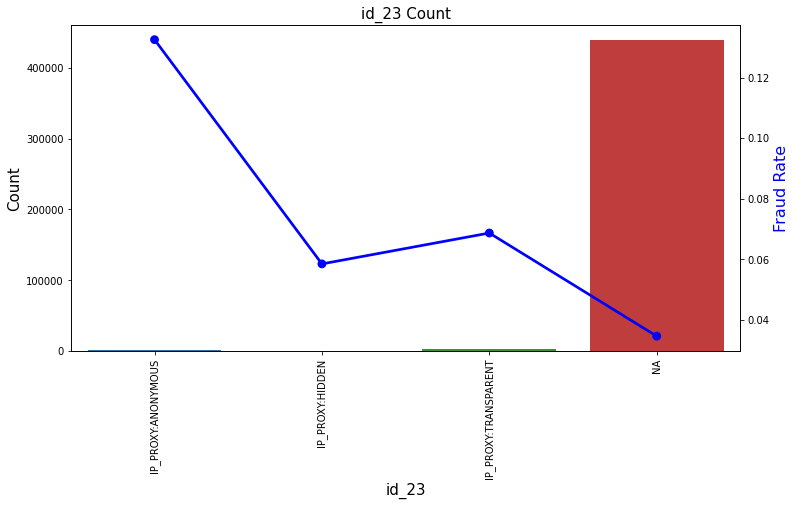

In [43]:
visualize_cat_cariable('id_23')

**Obervation**: The first notable id plot is the IP status. It is interesting to see the anonymous IP_Proxy would have a higher fraud rate. If someone were to commit a fraudulent transaction, it makes sense that the person would want to protect his/her identity.

### Operating Systems

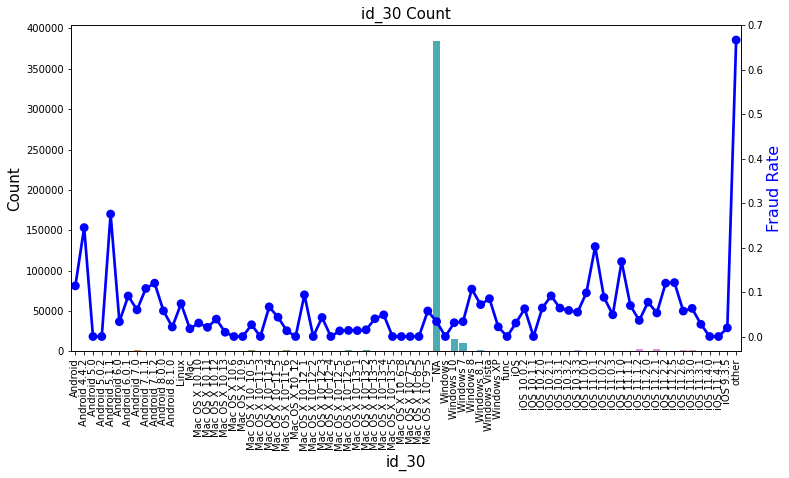

In [44]:
visualize_cat_cariable('id_30')

We can aggregate the operating system into a few major OSs. 

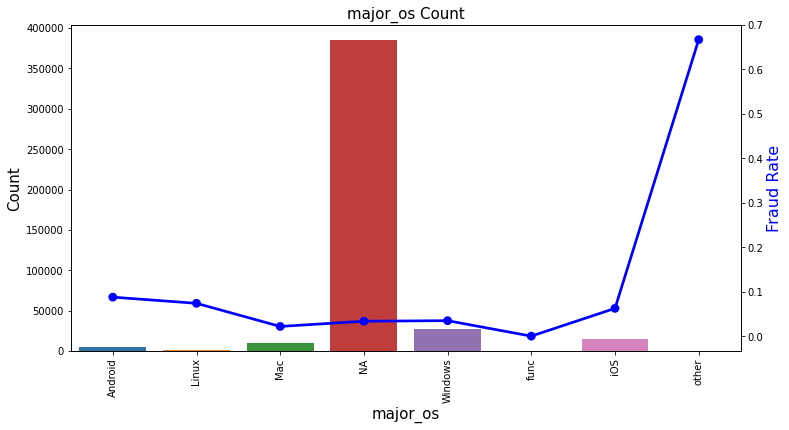

In [45]:
train_full['major_os'] = train_full["id_30"].str.split(' ', expand = True)[[0]]

visualize_cat_cariable('major_os')

**Observation**: The fraud rate across multiple well-known OSs seem fairly similar. "Other" operating systems have a much higher fraud rate.

However, it's strange that we see more IOS devices compared to Android, given that Android is the most popular mobile system. If I were to work for Vista, I would ask how the system collects more IOS instances. Could it be that Vista have given us an filtered dataset? Specific market segment? Systematic error or deficiency in collecting Android info?

### Browsers

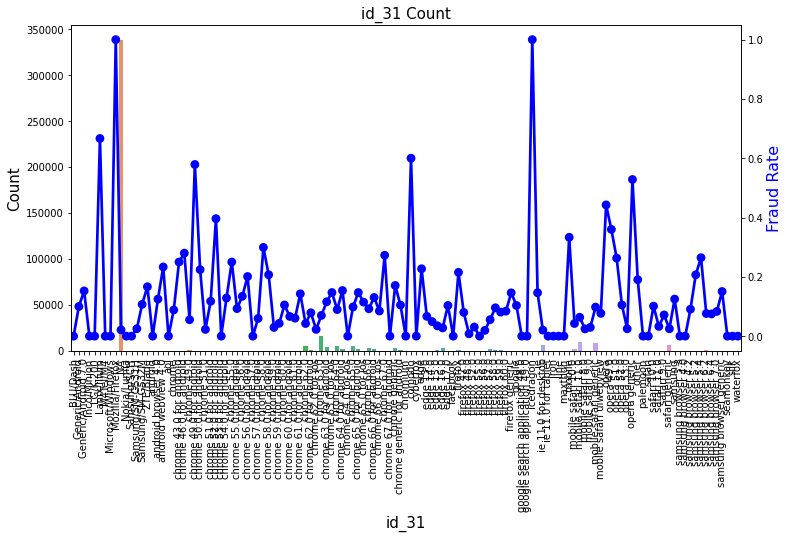

In [46]:
visualize_cat_cariable('id_31')

Same as previous plot, we need to reduce the number of categories using aggregation:

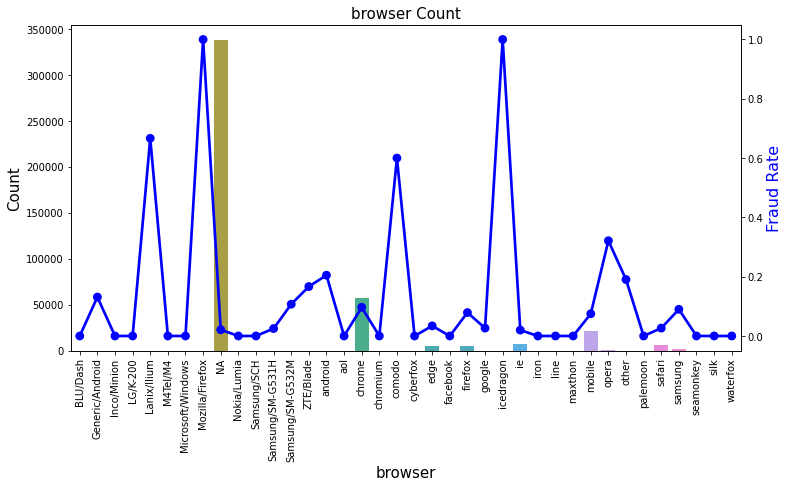

In [47]:
train_full['browser'] = train_full["id_31"].str.split(' ', expand = True)[[0]]

visualize_cat_cariable('browser')

We have a few browers that have absurdly high fraud rate. This is likely to due the scarcity of those browsers. We can fix this by apply a minimum-instance-filter. Let's say 0.1 percent of data rows is our cut-off, then each category must have at least 144 instances to be included in our plot:

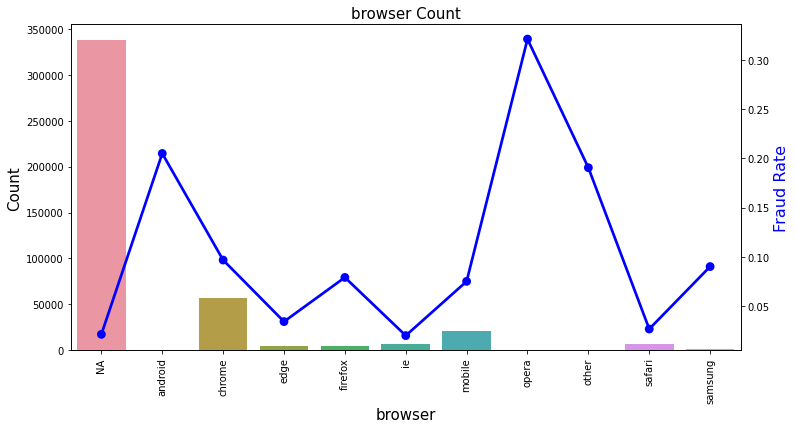

In [48]:
browser_list = train_full.groupby('browser').filter(lambda x: len(x) > 144)['browser'].unique()
visualize_cat_cariable('browser',  df = train_full[train_full['browser'].isin(browser_list)])

**Observation**: Opera and android browser have relatively high fraud rate

# Explore Numerical Features

I anticipate that most variables we will encounter would not follow a normal distribution. Therefore, for each variable, we will explore:

1. Distribution

2. Log of distribution

3. Distribution by target variable

4. Log of distribution by target variable

5. Boxplot comparison between fraud and non-fraud

## Examine Transaction Amount

In [49]:
def visualize_num_variable(variable, df=train_full):
    plt.figure(figsize=(12,18))
    plt.suptitle('Distribution of: {}'.format(variable), fontsize=22)

    plt.subplot(321)
    sns.distplot(df[variable], kde= False)
    plt.title('{} Distribution'.format(variable), fontsize = 15)

    plt.subplot(322)
    sns.distplot(np.log10(df[variable]), kde= False)
    plt.title('Log-transformed Distribution', fontsize = 15)


    plt.subplot(323)
    sns.distplot(df[df['isFraud'] == 0][variable], color = 'skyblue', kde= False, label = 'Not Fraud')
    sns.distplot(df[df['isFraud'] == 1][variable], color = 'red', kde= False , label = 'Fraud')
    plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
    plt.legend()

    plt.subplot(324)
    sns.distplot(np.log10(df[df['isFraud'] == 0][variable]), color = 'skyblue', kde= False, label = 'Not Fraud')
    sns.distplot(np.log10(df[df['isFraud'] == 1][variable]), color = 'red', kde= False , label = 'Fraud')
    plt.title('Log-transformed Distribution', fontsize = 15)
    plt.legend()
    
    plt.subplot(313)
    sns.boxplot(x = 'isFraud', y = variable, data = df)
    plt.title('Transaction Amount by Fraud', fontsize = 15,  weight='bold')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


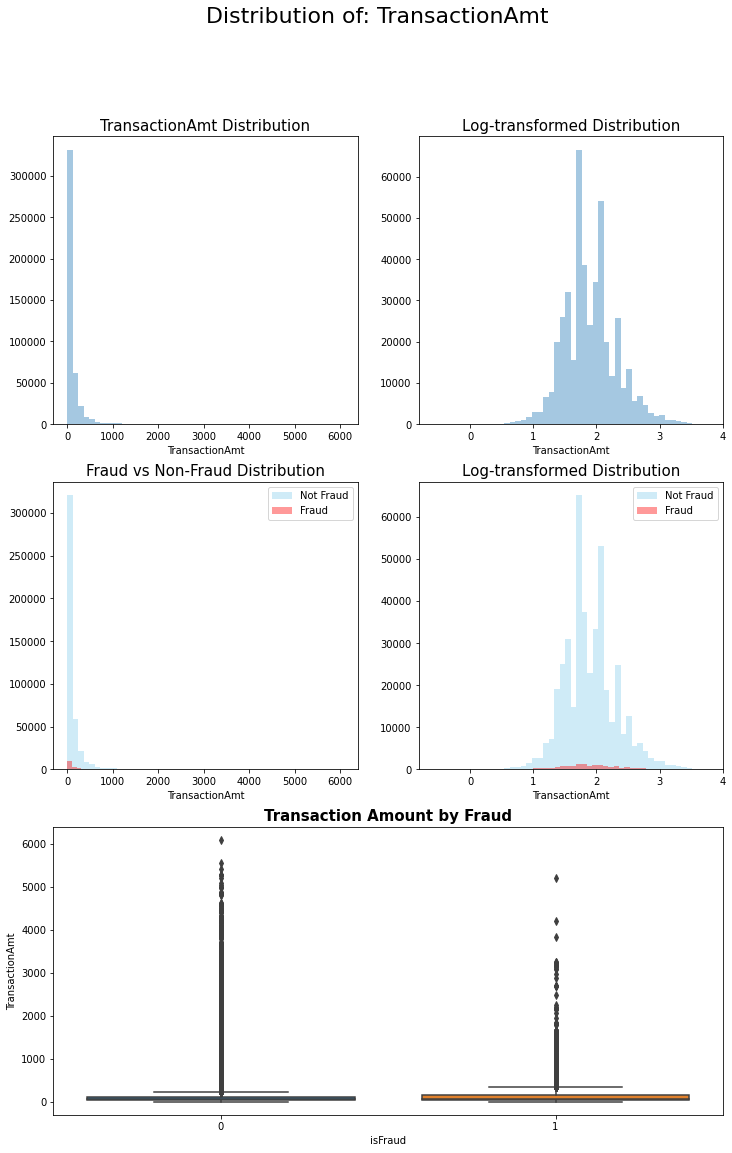

In [50]:
visualize_num_variable('TransactionAmt')

**Observation**: 
    1. TransactionAmt has right-skewed distribution: most transactions are small (less than $200)
    2. There is little difference between distribution and average amount for fraud and non-fraud

## Examine Transaction DT

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


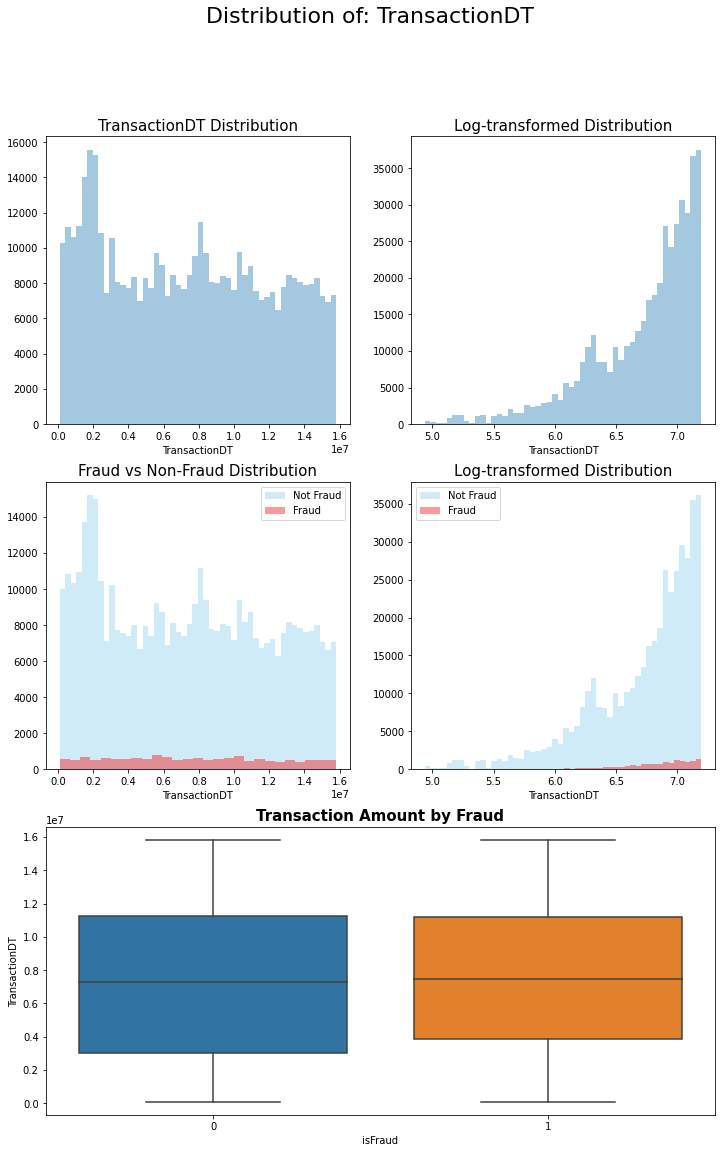

In [51]:
visualize_num_variable('TransactionDT')

**Observation**: There is a large number of non-fraud transactions generated at a certain period . This discrepancy also causing the difference in our boxplot.

**Possible Improvement**: I should try undersampling the period of non-fraud so that we have less imbalance issue for that particular period.

## Examine Distance 2

Dist1 contains no values. For dist2, we also running into two problems:

1. Missing values:

    Solution: keeping only the non-null rows in dist2.

2. Zero values:

    Zero values cause log transform to return infinity values

    Solution: add small amount to 0s to avoid infinity
    
3. Negative values
    
    The logarithm is only defined for positive numbers. I could perhaps take the log(x+n), where n is the offset values that make the min negative value > 0. However, for such data 0 has a meaning (equality!) that should be respected. Unless I know the meaning of the data, I cannot make arbitrary transformation.
    
    Solution: no solution, omit the log-transformation graphs

Let's update our graphing function with this implementation


In [52]:
def visualize_num_variable(variable, df=train_full.copy()):
    # check for homogeneity:
    if len(df[variable].unique()) <= 1:
        print('{} is a homogeneous set'.format(variable))
        return
    
    # check for NAs and Zeros
    if df[variable].isnull().values.any():
        df = train_full.dropna(subset=[variable])

    if df[variable].min() < 0:
        plt.figure(figsize=(12,12))
        plt.suptitle('Distribution of: {}'.format(variable), fontsize=22)
    
        plt.subplot(221)
        sns.distplot(df[variable], kde= False)
        plt.title('{} Distribution'.format(variable), fontsize = 15)
        
        plt.subplot(222)
        sns.distplot(df[df['isFraud'] == 0][variable], color = 'skyblue', kde= False, label = 'Not Fraud')
        sns.distplot(df[df['isFraud'] == 1][variable], color = 'red', kde= False , label = 'Fraud')
        plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
        plt.legend()
        
        plt.subplot(212)
        sns.boxplot(x = 'isFraud', y = variable, data = df)
        plt.title('{} by Fraud'.format(variable), fontsize = 15,  weight='bold')
        
    else:
        smallest_value = df[df[variable] != 0][variable].min()
        if df[variable].min() == 0:
            df[variable].replace(0, smallest_value/10, inplace=True)       

        plt.figure(figsize=(12,18))
        plt.text(x=0.5, y=0.5,
                 s="Zeros have been replaced with {} to avoid log infinity".format(smallest_value/10),
                 fontsize=12,horizontalalignment='center')

        plt.suptitle('Distribution of: {}'.format(variable), fontsize=22)

        plt.subplot(321)
        sns.distplot(df[variable], kde= False)
        plt.title('{} Distribution'.format(variable), fontsize = 15)

        plt.subplot(322)
        sns.distplot(np.log10(df[variable]), kde= False)
        plt.title('Log-transformed Distribution', fontsize = 15)


        plt.subplot(323)
        sns.distplot(df[df['isFraud'] == 0][variable], color = 'skyblue', kde= False, label = 'Not Fraud')
        sns.distplot(df[df['isFraud'] == 1][variable], color = 'red', kde= False , label = 'Fraud')
        plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
        plt.legend()

        plt.subplot(324)
        sns.distplot(np.log10(df[df['isFraud'] == 0][variable]), color = 'skyblue', kde= False, label = 'Not Fraud')
        sns.distplot(np.log10(df[df['isFraud'] == 1][variable]), color = 'red', kde= False , label = 'Fraud')
        plt.title('Log-transformed Distribution', fontsize = 15)
        plt.legend()

        plt.subplot(313)
        sns.boxplot(x = 'isFraud', y = variable, data = df)
        plt.title('{} by Fraud'.format(variable), fontsize = 15,  weight='bold')

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


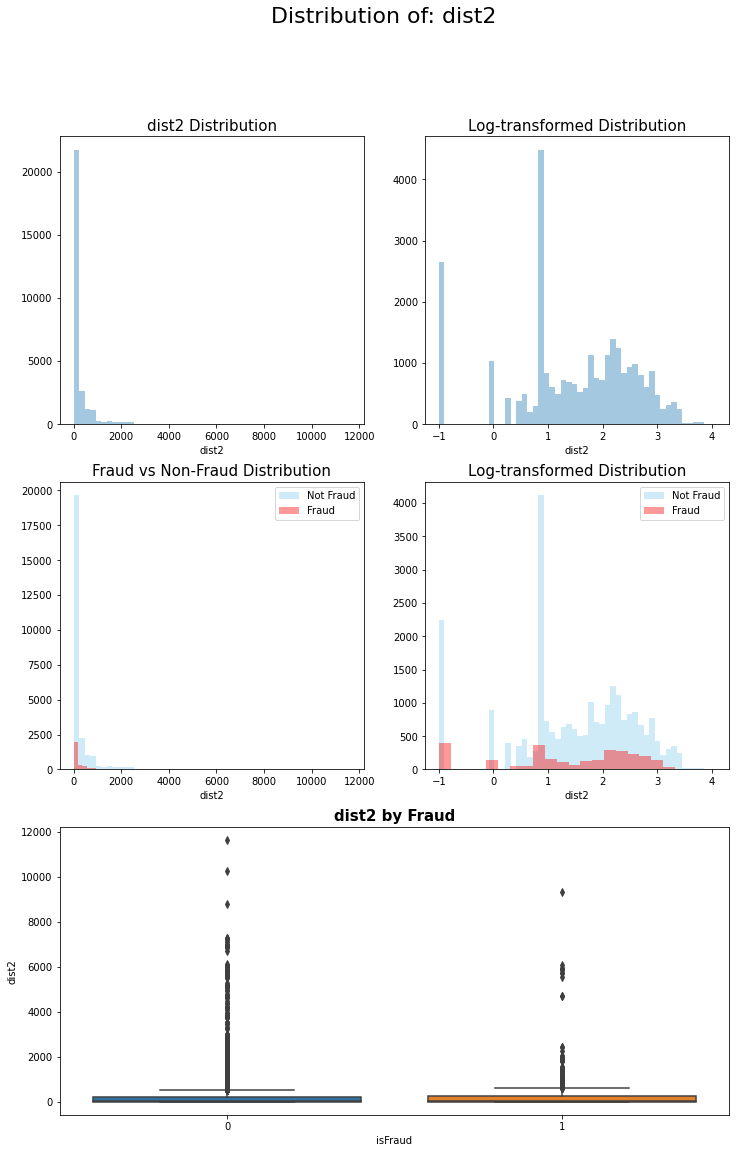

In [53]:
visualize_num_variable('dist2')

**Observation**: Dist2 does not seem to varies between fraud and not-fraud

## Examine C features

Same way of handling a large number of variables, I only choose the notable plots that reflect a large degree of variation. Trying to keep this kernel concised is one of my goals. In this case, I only consider C3 to have some significant patterns:

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


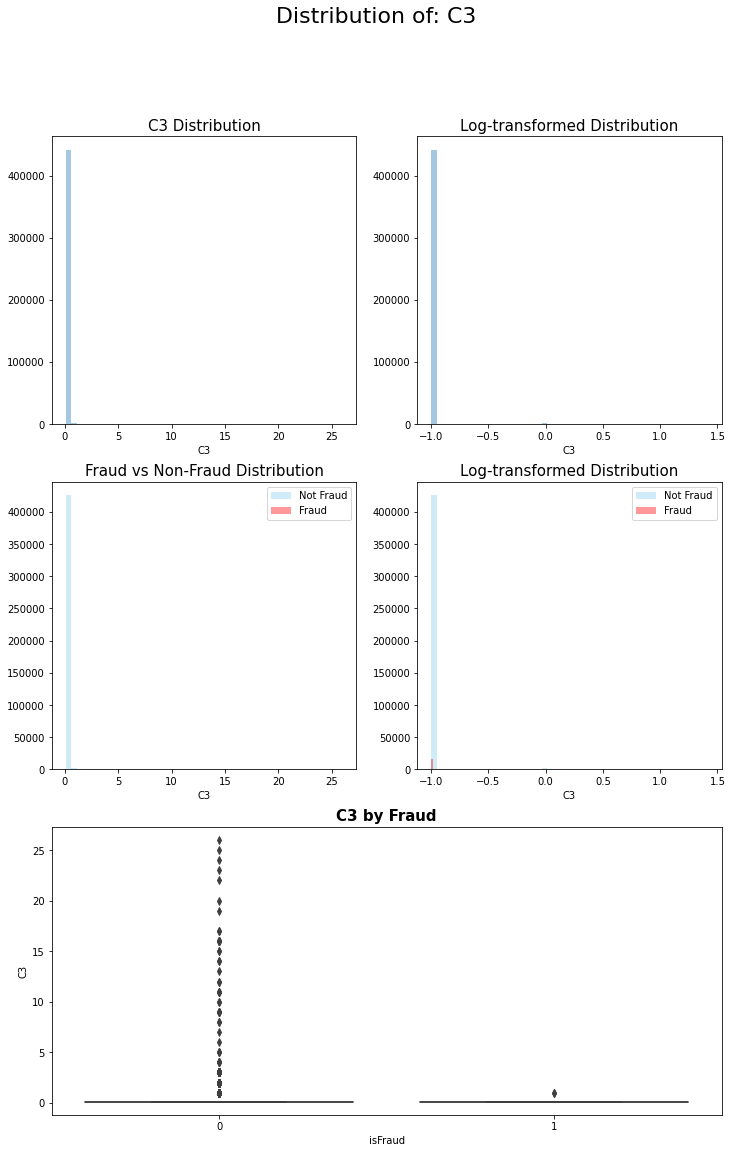

In [54]:
visualize_num_variable('C3')

**Observation**: Higher values of C3 associated with no-fraud.

C5 and C9 are homogeneous columns.

## Examine D features

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self

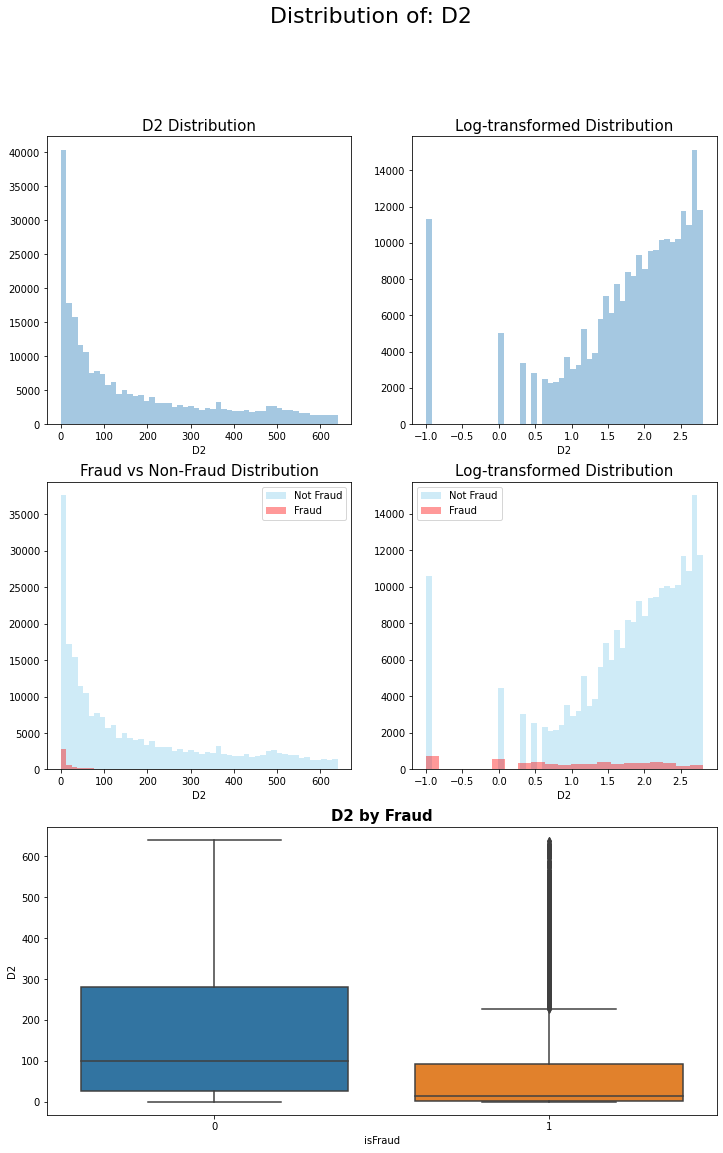

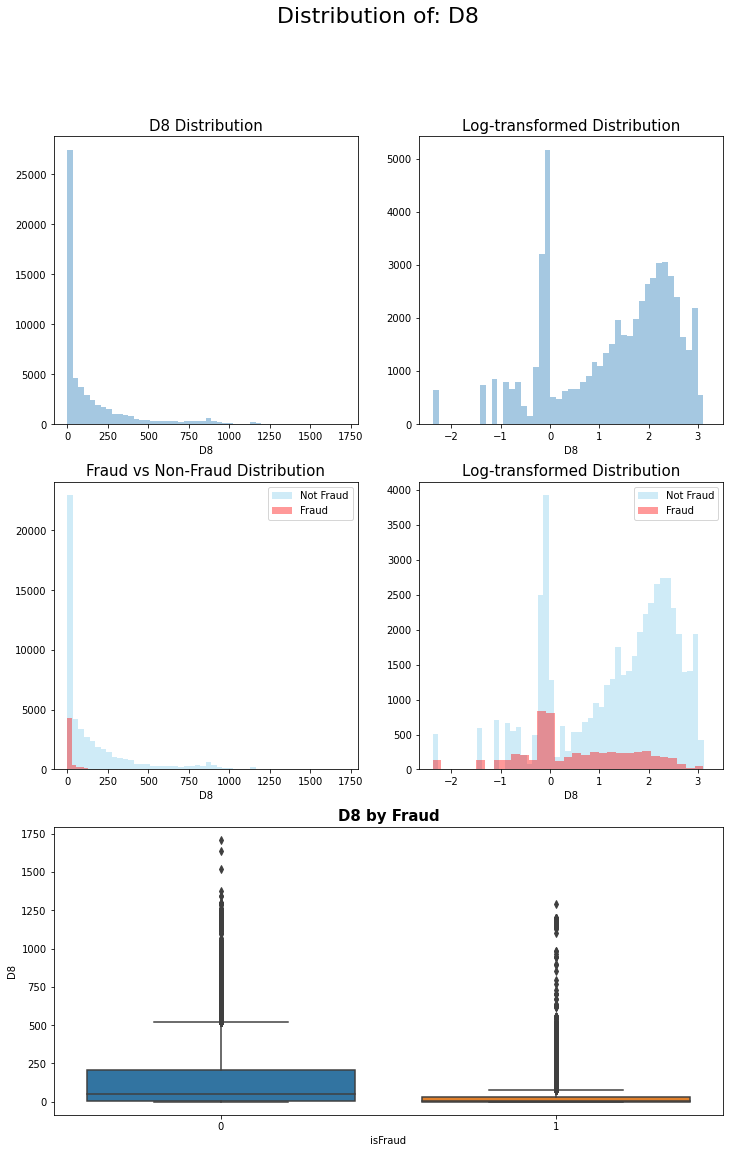

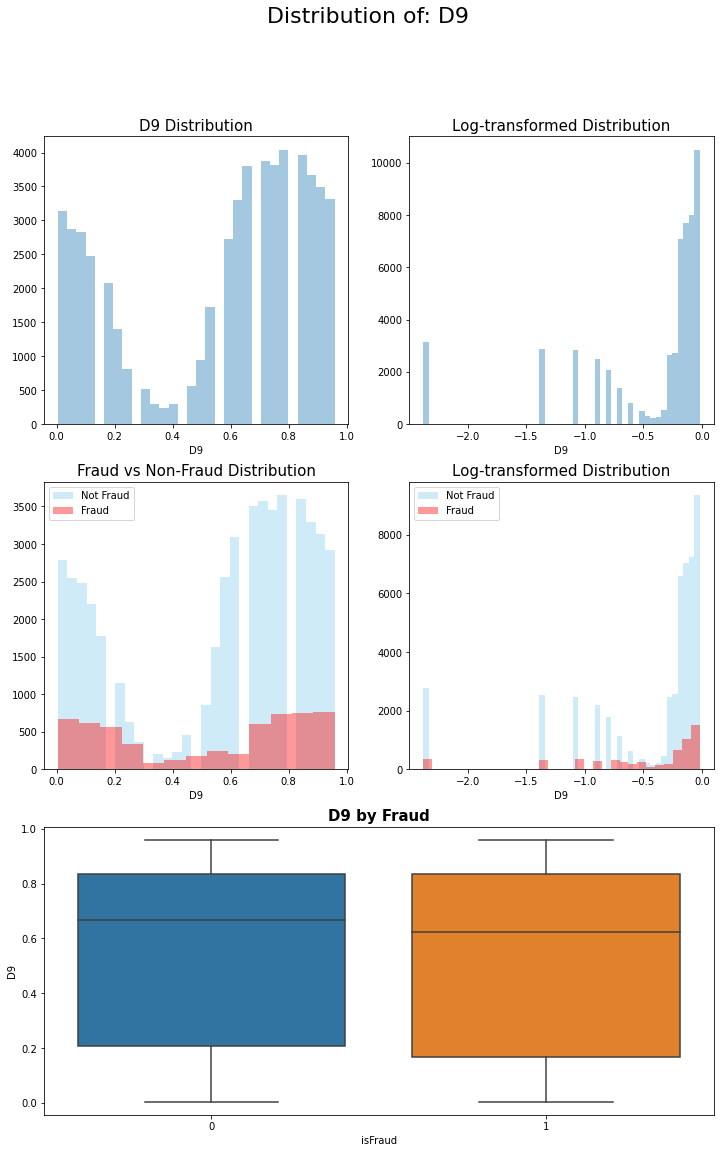

In [55]:
visualize_num_variable('D2')
visualize_num_variable('D8')
visualize_num_variable('D9')

## Conclusion for EDA:

1. Target variable has class imbalance problem where instance of fraud is much lower than non-fraud

2. Multiple columns contain too many missing values

3. Several columns are homogeneous, therefore, prodvide no useful information in predicting the target variable (this may not be the case for transaction table since we are using a joined table)

4. There is period of time where instances of non-fraud far exceed the usual proportion of non-fraud to fraud 

5. Basic understand of variables can help us do simple feature engineering

We will deal with each problem with the purpose of improving the prediction accuracy. But first, let's try a default XGBoost model provided by Vesta. We can use this model as a baseline to compare the improvement (or reduction) of each engineered feature, change, and alteration that  we made along the way.

## Brainstorm
Before treating this problem like a black box of ensemble learning, it's worthwhile to take our hands off the keyboards and think about the problem of fraud detection in a more "open-box" way. There are a lot of intersting questions worth investigating before diving into the madness of hyperparameters tuning. Insights that could lead to trivial and sometimes important questions. Questions that take us on a journey of curiosity and fulfilment. 

For the data scientists whose minds love to wander. This section is dedicated for silly and serious questions alike.

**Scenario** :A Vesta executive storms in the office and excitedly tells everyone that an exciting project has fallen in their laps. It's the fraud detection problem. And he ask his people for some ideas of where to start, which features should be useful in prediciting fraud. He knows it is strange to ask the scientists before attempting any EDA or modeling. After all, they haven't seen a lick of relevant data. But he saids it would be great practive to dip the toe into the water before diving in without any direction. So let's start with the few things that were provided to us: transaction amount, time, card infor, identity, etc... Which information would give us a good start at cracking this problem?

Let's define clearly what is a fraud transaction first. "Fraud detection is a set of activities undertaken to prevent money or property from being obtained through false pretenses" [Source](https://searchsecurity.techtarget.com/definition/fraud-detection). Most common type of frauds are forging checks or using stolen credit cards. If a person got of hold of your card info, what should he/she do with it? After browsing on Reddit, I found some crude scenarios:

1. If you drop your card, it's likely the person who found it by chance and commit a fraud would spend it on consumable and essential products like grocery and gas. The perp will likely go somewhere nearby and spend a larger amount than usual before the card get locked. So perhaps we should look at user's purchase history so that any activities or purchases that deviate from normal buying habit would stand out. But we don't have identifiable data, so we can't go on this route.

2. If your information get hacked by careless purchases on some shady websites/gas stations, it's likely that your information will be sold to someone else who use your information for making fraud transaction. This person will make an online purchase and ship it to a distributor, who sells the good for cash and share the profit with the frauder. In this situation, the good is shipped to some far-away place from the user's home address. So the further the distance, the more a transaction looks like a fraud? No, of course not. People sends gifts all the times. But perhaps gifting 3 expensive laptops is slightly more suspicious than gifting a box of chocolate.
    
    **Feature Engineering:** Combine transaction amount, type of good, and distance together.
    
3. Fraud commited by someone close to you (family member: spouse, siblings, etc). It's rare, but it could happen.

4. Prefered tools for committing fraud. We have learned previously in the EDA that Protonmail has exceptionally high fraud rate >95%. A quick google reveal that Proton is a email service that provide free, anonymous, end-to-end encryption email accounts. Quote from Proton website: "ProtonMail is incorporated in Switzerland and all our servers are located in Switzerland. This means all user data is protected by strict Swiss privacy laws". Meaning fraud perpetrator not only protected by the full extend of the privacy law, but also doing it at no cost. Similarly, we have other tools that also have abnormally high fraud rate such as:

    * Browser: Comodo IceDragon, Mozilla/Firefox?? (not firefox, but perhaps is Comodo IceDragon but recognized as another version of Firefox?)
    
    * Operating system: "other" category has fraud rate of 60%.
    
    * Phone (or browser?): Lanix Ilium
    
    **Feature Engineering:** New features that emphasize the importance of these tools
    
5. Time of operation. Just like any other jobs, frauders operate at routinely hours that perhaps different from the real users. It is strange, at least to me, to make purchase decision to buy an iphone at 3 in the morning. Again, without historical data, this approach is dead in the egg.


# Baseline Model

Modeling section is being explore in another private notebook since only 1 GPU instance is allow in Kaggle Kernel...